<a href="https://colab.research.google.com/github/DhanvinS/ML_Models-Supervised-and-Unsupervised/blob/main/Spectral_Clustering%2C_K_Means%2C_MDS%2C_Isomap%2C_and_LLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import MDS
import pandas as pd

In [28]:
from google.colab import files
files = files.upload()

Saving Data_Iris.csv to Data_Iris (1).csv


In [29]:
def load_iris_data(csv_path="Data_Iris.csv"):
        print(f"Loading data from {csv_path}")
        df = pd.read_csv(csv_path)
        # first four columns to be features and last column species name
        X = df.iloc[:, :4].values.astype(float)
        labels_raw = df.iloc[:, 4].values
        # im Mapping textual labels to integers 0,1,2
        uniques, y = np.unique(labels_raw, return_inverse=True)
        target_names = uniques.tolist()
        return X, y, target_names

In [30]:
X, y, target_names = load_iris_data()

np.random.seed(0)
n_samples = X.shape[0]

Loading data from Data_Iris.csv


In [31]:
# Affinity matrix (RBF) helper and normalized spectral clustering
def rbf_affinity(X, sigma=None):
    D = pairwise_distances(X, metric='euclidean')
    if sigma is None:
        # using median of pairwise distances
        upper = D[np.triu_indices_from(D, k=1)]
        sigma = np.median(upper)
    A = np.exp(- (D ** 2) / (2.0 * (sigma ** 2)))
    np.fill_diagonal(A, 0.0)
    return A, sigma

In [32]:
def normalized_spectral_clustering(X, n_clusters, sigma=None, n_init_kmeans=50):
    A, sigma_used = rbf_affinity(X, sigma)
    # degree matrix
    D = np.diag(A.sum(axis=1))
    D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D) + 1e-12))
    L_sym = np.eye(X.shape[0]) - D_inv_sqrt.dot(A).dot(D_inv_sqrt)
    # eigen decomposition -> smallest eigenvalues
    eigvals, eigvecs = linalg.eigh(L_sym)
    U = eigvecs[:, :n_clusters]          # taking first k eigenvectors (columns)
    # row-normalize U
    U_norm = U / np.linalg.norm(U, axis=1, keepdims=True)
    # k-means on rows of U_norm
    km = KMeans(n_clusters=n_clusters, n_init=n_init_kmeans, random_state=0).fit(U_norm)
    labels = km.labels_
    return labels, {'A': A, 'sigma': sigma_used, 'L_sym': L_sym, 'U': U_norm, 'eigvals': eigvals[:n_clusters]}

In [33]:
k = 3
spec_labels, spec_info = normalized_spectral_clustering(X, k)
km_orig = KMeans(n_clusters=k, n_init=50, random_state=0).fit(X)
km_labels = km_orig.labels_

ari_spec = adjusted_rand_score(y, spec_labels)
nmi_spec = normalized_mutual_info_score(y, spec_labels)
ari_km = adjusted_rand_score(y, km_labels)
nmi_km = normalized_mutual_info_score(y, km_labels)

print("\n--- Clustering evaluation ---")
print(f"Spectral clustering (k={k})  -> ARI: {ari_spec:.4f}, NMI: {nmi_spec:.4f}")
print(f"KMeans (original features)  -> ARI: {ari_km:.4f}, NMI: {nmi_km:.4f}")
print(f"RBF sigma used for affinity: {spec_info['sigma']:.6g}")


--- Clustering evaluation ---
Spectral clustering (k=3)  -> ARI: 0.7163, NMI: 0.7419
KMeans (original features)  -> ARI: 0.7302, NMI: 0.7582
RBF sigma used for affinity: 2.36008


In [34]:
# Plot helper
def scatter_by_label(Z2, labels_true, title="", xlabel="", ylabel="", target_names=None, marker='o'):
    plt.figure(figsize=(6,5))
    for lab in np.unique(labels_true):
        plt.scatter(Z2[labels_true==lab, 0], Z2[labels_true==lab, 1], label=(target_names[lab] if target_names is not None else str(lab)), marker=marker)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()



Computing MDS (Euclidean) ...


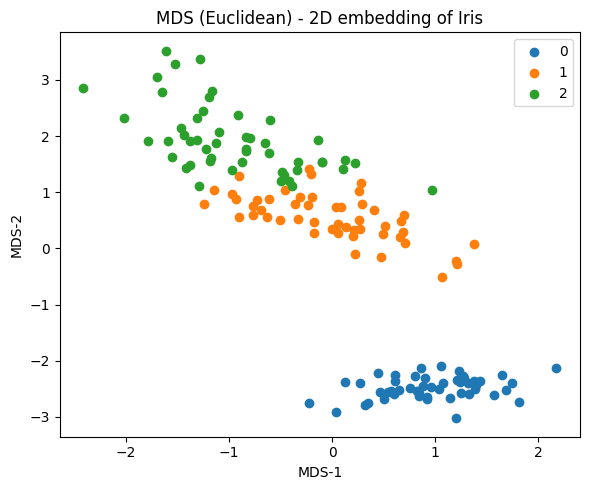

In [35]:
# (a) MDS (Euclidean)
print("\nComputing MDS (Euclidean) ...")
mds = MDS(n_components=2, dissimilarity='euclidean', random_state=0)
X_mds = mds.fit_transform(X)
scatter_by_label(X_mds, y, title="MDS (Euclidean) - 2D embedding of Iris", xlabel="MDS-1", ylabel="MDS-2", target_names=target_names)


In [36]:
# (b) Isomap
def classical_mds_from_distances(D2, n_components=2):
    n = D2.shape[0]
    J = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * J.dot(D2).dot(J)
    eigvals, eigvecs = linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1]
    vals = eigvals[idx][:n_components]
    vecs = eigvecs[:, idx][:, :n_components]
    # numeric guard
    vals[vals < 0] = 0.0
    return vecs * np.sqrt(vals)

In [37]:
def isomap_transform(X, n_neighbors=6, n_components=2):
    D = pairwise_distances(X, metric='euclidean')
    n = D.shape[0]
    # Building kNN adjacency: for each i connect to its k nearest
    knn_idx = np.argsort(D, axis=1)[:, 1:n_neighbors+1]
    rows = np.repeat(np.arange(n), n_neighbors)
    cols = knn_idx.ravel()
    data = D[np.repeat(np.arange(n), n_neighbors), cols]
    G = csr_matrix((data, (rows, cols)), shape=(n, n))
    # symmetrize
    G = G.minimum(G.transpose())
    # shortest-path distances
    graph_dist = shortest_path(csgraph=G, directed=False, unweighted=False)
    # if any infinite distances , replacing with a big finite number
    if np.isinf(graph_dist).any():
        finite_max = np.nanmax(np.where(np.isfinite(graph_dist), graph_dist, np.nan))
        graph_dist[np.isinf(graph_dist)] = finite_max * 10.0
    D2 = graph_dist ** 2
    return classical_mds_from_distances(D2, n_components=n_components)


Computing Isomap embeddings (n_neighbors = 6, 12, 20) ...
  Isomap n_neighbors=6


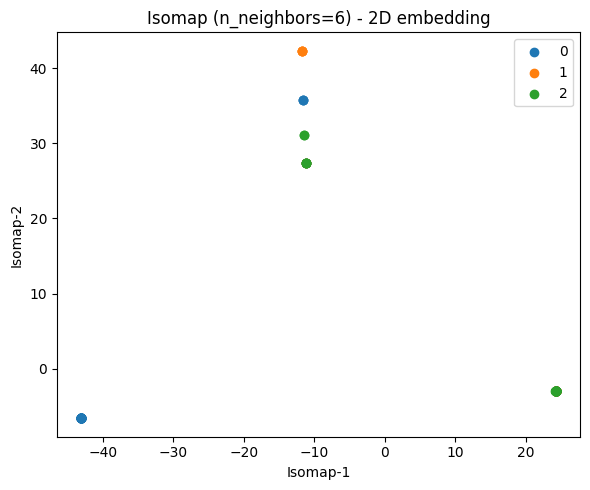

  Isomap n_neighbors=12


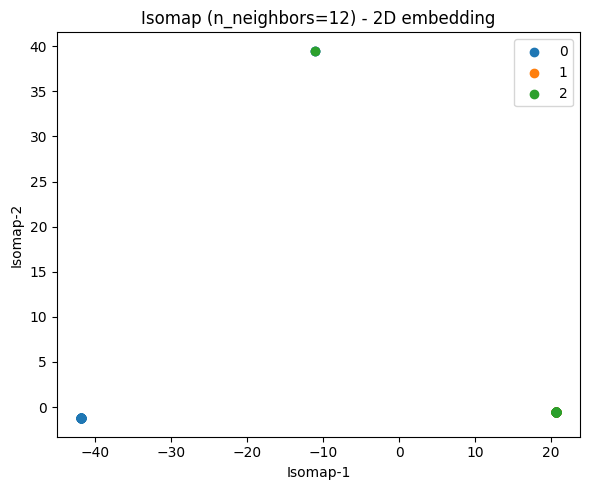

  Isomap n_neighbors=20


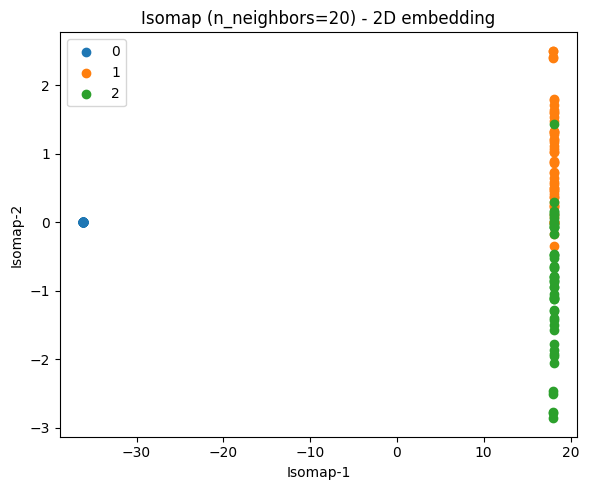

In [38]:
print("\nComputing Isomap embeddings (n_neighbors = 6, 12, 20) ...")
for nnb in [6, 12, 20]:
    print(f"  Isomap n_neighbors={nnb}")
    X_iso = isomap_transform(X, n_neighbors=nnb, n_components=2)
    scatter_by_label(X_iso, y, title=f"Isomap (n_neighbors={nnb}) - 2D embedding", xlabel="Isomap-1", ylabel="Isomap-2", target_names=target_names)



Computing custom LLE embeddings (n_neighbors = 6,10,20,25) ...
  LLE n_neighbors=6


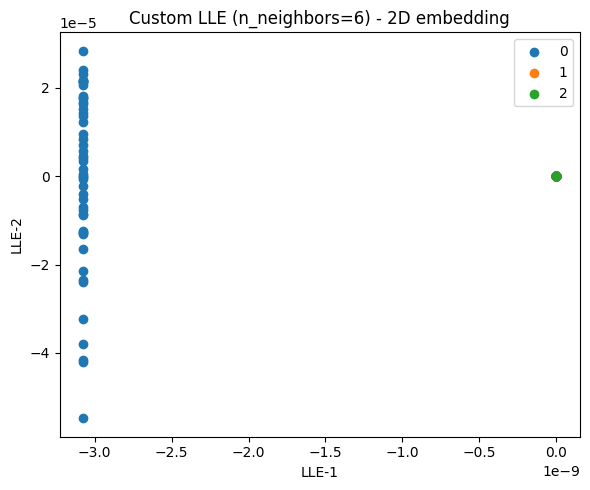

  LLE n_neighbors=10


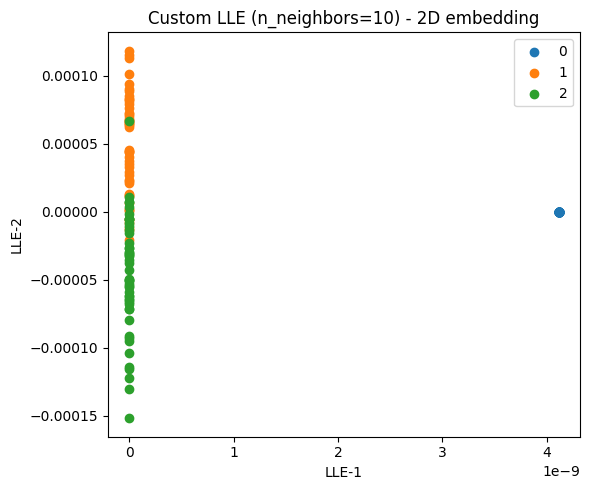

  LLE n_neighbors=20


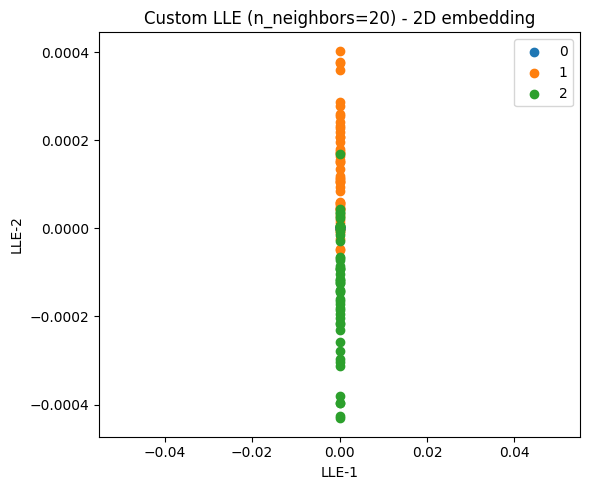

  LLE n_neighbors=25


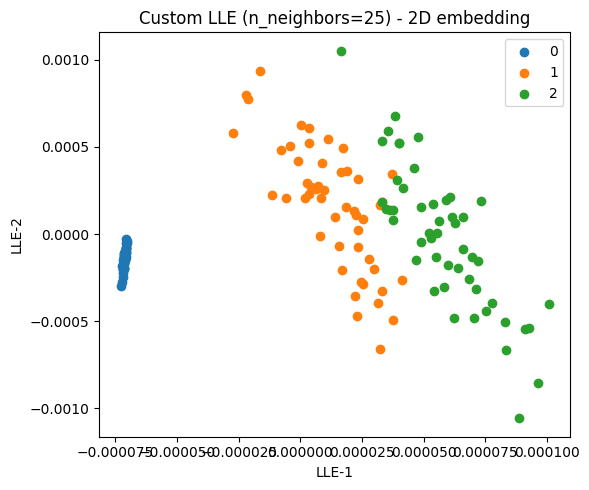

In [39]:
# (c) Locally Linear Embedding
def lle_transform(X, n_neighbors=6, n_components=2, reg=1e-3):
    n_samples = X.shape[0]
    D = pairwise_distances(X, metric='euclidean')
    neighbors = np.argsort(D, axis=1)[:, 1:n_neighbors+1]
    W = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        Xi = X[i]
        nbrs = X[neighbors[i]]          # shape (k, d)
        Z = (nbrs - Xi)                 # shape (k, d)
        C = Z.dot(Z.T)                  # local covariance (k x k)
        traceC = np.trace(C)
        if traceC == 0:
            C = C + reg * np.eye(C.shape[0])
        else:
            C = C + reg * traceC * np.eye(C.shape[0])
        # Solve C w = 1 and normalize
        w = np.linalg.solve(C, np.ones(C.shape[0]))
        w = w / np.sum(w)
        W[i, neighbors[i]] = w
    I = np.eye(n_samples)
    M = (I - W).T.dot(I - W)
    eigvals, eigvecs = linalg.eigh(M)
    idx = np.argsort(eigvals)
    # skip first eigenvector (near-zero eigenvalue)
    vecs = eigvecs[:, idx[1:n_components+1]]
    vals = eigvals[idx[1:n_components+1]]
    vals[vals < 0] = 0.0
    return vecs * np.sqrt(vals)

print("\nComputing custom LLE embeddings (n_neighbors = 6,10,20,25) ...")
for nnb in [6, 10, 20, 25]:
    print(f"  LLE n_neighbors={nnb}")
    X_lle = lle_transform(X, n_neighbors=nnb, n_components=2)
    scatter_by_label(X_lle, y, title=f"Custom LLE (n_neighbors={nnb}) - 2D embedding", xlabel="LLE-1", ylabel="LLE-2", target_names=target_names)
